In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.analysis import circular_stats
import os 
seed = 2023

### Define functions

In [25]:
def moving_average(data:np.ndarray,win:int,step:int=1)-> np.ndarray:
    d_shape=data.shape
    count = 0
    if len(d_shape) == 3:
        d_avg = np.zeros((d_shape[0],d_shape[1],int(np.floor(d_shape[2]/step))))
        for i_step in np.arange(0,d_shape[2]-win,step):
            d_avg[:,:,count] = np.mean(data[:,:,i_step:i_step+win],axis=2)
            count +=1
    if len(d_shape) == 1:
        d_avg = np.zeros((int(np.floor(d_shape[0]/step))))
        for i_step in np.arange(0,d_shape[0]-win,step):
            d_avg[count] = np.mean(data[i_step:i_step+win],axis=0)
            count +=1

    return d_avg

In [26]:
def get_task_variables(data:SpikeData,bhv:BhvData):
    # Select trials (correct and DMTS task) and create task frame
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]

    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=bhv.condition[trial_idx],
        test_stimuli=bhv.test_stimuli[trial_idx],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    cgroup = "all"
    in_out='in'
    if cgroup == 'all':
        neurons = np.where(data.clustersgroup != cgroup)[0]
    else:
        neurons = np.where(data.clustersgroup == cgroup)[0]
    # print("Number of clusters: %d" % len(data.clustersgroup))
    #print("Number of %s units: %d" % (cgroup, len(neurons)))
    task = task[task['in_out']==in_out]


    return task, trial_idx

In [27]:
def get_trials_by_sample(task,feature,trial_idx,bhv,data):
    sample_trials = {"o1":np.array([]),"o5":np.array([]),"c1":np.array([]),"c5":np.array([])}
    
    for key_sample in sample_trials.keys():
        sample_trials[key_sample]=np.unique(task.loc[task['sample'].str.contains(key_sample, case=False)]['trial_idx'].values)

    test_stimuli = bhv.test_stimuli[trial_idx][sample_trials[feature]]
    code_numbers = data.code_numbers[trial_idx][sample_trials[feature]]
    code_samples = data.code_samples[trial_idx][sample_trials[feature]]
    sp_samples = data.sp_samples[trial_idx][sample_trials[feature]]
    return test_stimuli,code_numbers,code_samples,sp_samples,sample_trials

In [28]:
def delete_match(test_stimuli,code):
    code = (code-1).astype(int)
    tests_shape=test_stimuli.shape
    test_stimuli = np.concatenate([test_stimuli,np.ones((tests_shape[0],1))],axis=1)
    test_stimuli[np.arange(tests_shape[0]),code] =  np.nan
    test_stimuli = test_stimuli[:,:tests_shape[1]]
    return test_stimuli.astype(str)

In [29]:
def get_sample_avg_fr(task,sp_samples,test_stimuli,code_samples,color_orient:int=0):
    n_trials = np.zeros((8,4))
    samples_dicts = {"o1_c1":{},"o1_c5":{},"o5_c1":{},"o5_c5":{}}
    stim_num=['1','2','3','4','5','6','7','8']
    for i_sam,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
        task_sample = task[task['sample']==sample]
        test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
        # code_numbers_samp = code_numbers[task_sample['trial_idx']]
        code_samples_samp = code_samples[task_sample['trial_idx']]
        sp_samples_samp = sp_samples[task_sample['trial_idx']]
        code = task_sample['code'].values
        test_stimuli_samp = delete_match(test_stimuli_samp,code)
        #test_stimuli_samp = delete_match(test_stimuli_samp)

        for i_num,i_stim in enumerate(stim_num):
            i_trial, i_test = np.where(np.char.find(test_stimuli_samp,i_stim)==color_orient)
            tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
            sp_stim = sp_samples_samp[i_trial]
            sp_tests = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 100:400]
            if np.isnan(np.sum(sp_tests)):
                raise ValueError('nan values')
            samples_dicts[sample][i_stim] = sp_tests.mean(axis=1)*1000
            n_trials[i_num,i_sam] =sp_tests.shape[0]

    return samples_dicts,n_trials

In [30]:
def select_rand_trials_from_samples(sample1,sample2,samples_dicts,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]
    for n_it in range(n_iterations):
        np.random.seed(it_seed[n_it]) 
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr_s1 = np.random.choice(samples_dicts[sample1][i_stim], size=min_n_trials[i_num], replace=True, p=None)
            fr_s2 = np.random.choice(samples_dicts[sample2][i_stim], size=min_n_trials[i_num], replace=True, p=None)
            fr = np.concatenate([fr_s1,fr_s2])
            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

In [31]:
def get_null_vector_from_samples(sample1,sample2,samples_dicts,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]

     
    # all_sample1 = np.concatenate(list(samples_dicts[sample1].values()))
    # all_sample2 = np.concatenate(list(samples_dicts[sample2].values()))

    for n_it in range(n_iterations):
        all_sample1 = []
        all_sample2 = []
        np.random.seed(it_seed[n_it]) 
        for i_num,i_stim in enumerate(stim_num):
            all_sample1.append(np.random.choice(samples_dicts[sample1][i_stim], size=min_n_trials[i_num], replace=False, p=None))
            all_sample2.append(np.random.choice(samples_dicts[sample2][i_stim], size=min_n_trials[i_num], replace=False, p=None))
        all_sample1 = np.concatenate(all_sample1)
        all_sample2 = np.concatenate(all_sample2)  
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr_s1 = np.random.choice(all_sample1, size=min_n_trials[i_num], replace=True, p=None)
            fr_s2 = np.random.choice(all_sample2, size=min_n_trials[i_num], replace=True, p=None)
            fr = np.concatenate([fr_s1,fr_s2])

            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

In [32]:
## Permutation test
def permutation_test(mean_select,mean_null):
    radius = mean_select[:,0]
    angle =  mean_select[:,1]
    X = (np.array(radius) * np.cos(angle))
    Y = (np.array(radius) * np.sin(angle))
    ampl_dir_vector = np.sqrt(X**2+Y**2)
    radius = mean_null[:,0]
    angle =  mean_null[:,1]
    X = (np.array(radius) * np.cos(angle))
    Y = (np.array(radius) * np.sin(angle))
    ampl_null_vector = np.sqrt(X**2+Y**2)
    diff=[]
    for i in range(len(ampl_dir_vector)):
        shift = np.concatenate([ampl_dir_vector[i:],ampl_dir_vector[:i]])
        diff.append(shift-ampl_null_vector)
    diff=np.concatenate(diff)
    p_value = np.sum(diff<0)/len(diff)
    return p_value

In [33]:
def get_sample_avg_fr_trials(task,sp_samples,test_stimuli,code_samples,color_orient:int=0):
    n_trials = np.zeros((8,4))
    samples_dicts = {"o1_c1":{},"o1_c5":{},"o5_c1":{},"o5_c5":{}}
    stim_num=['1','2','3','4','5','6','7','8']
    for i_sam,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
        task_sample = task[task['sample']==sample]
        test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
        # code_numbers_samp = code_numbers[task_sample['trial_idx']]
        code_samples_samp = code_samples[task_sample['trial_idx']]
        sp_samples_samp = sp_samples[task_sample['trial_idx']]

        code = task_sample['code'].values
        test_stimuli_samp = delete_match(test_stimuli_samp,code)

        for i_num,i_stim in enumerate(stim_num):
            i_trial, i_test = np.where(np.char.find(test_stimuli_samp,i_stim)==color_orient)
            tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
            sp_stim = sp_samples_samp[i_trial]
            sp_tests = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:400]
            if np.isnan(np.sum(sp_tests)):
                raise ValueError('nan values')
            samples_dicts[sample][i_stim] = sp_tests
            n_trials[i_num,i_sam] =sp_tests.shape[0]



    return samples_dicts,n_trials

### Read paths

In [34]:
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_bhv_lip.txt", "r")
lines_bhv = file1.readlines()
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_sp_lip.txt", "r")
lines_sp = file1.readlines()
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())

### Direction selectiivity 
* The neuron is selective to orientation if the permutation test is significant for orientation 1 or orientation 5
* Using direction vectors coupled with permutation tests.
* Quantify the preferred direction independently for each condition computing directional vectors
  * 1 direction vectors: 

### Define parameters

In [35]:
orient = 0 
color = 1
n_iterations = 1000
win=100
step=1
samp_orient = (["o1_c1","o5_c1"],["o1_c5","o5_c5"])
samp_color = (["o1_c1","o1_c5"],["o5_c1","o5_c5"])
samp_orient_color = samp_orient
o_c = [orient,orient]
color_orient = orient


In [36]:
paths_sp[16:17]

['/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2023-02-09_10-42-54_Riesling_lip_e1_r1_sp.h5']

/tmp/ipykernel_124573/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


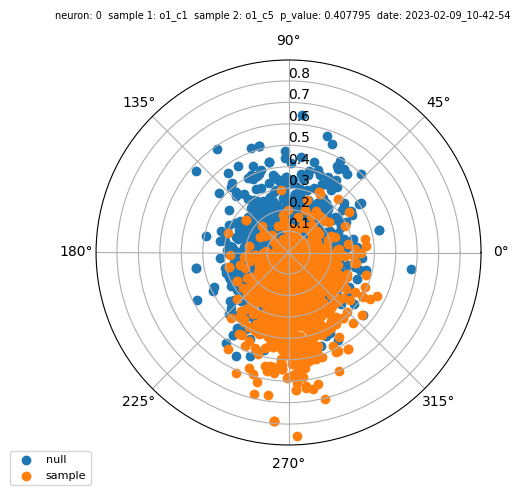

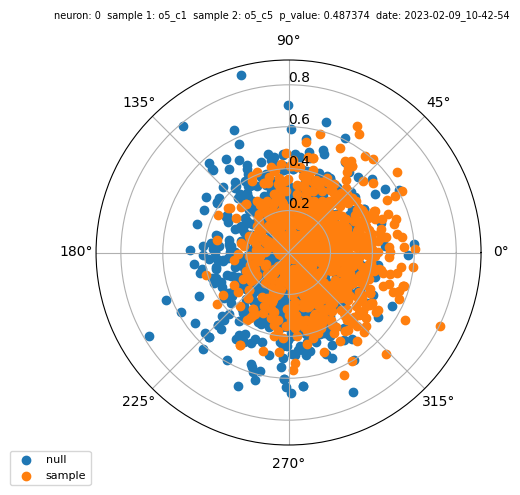

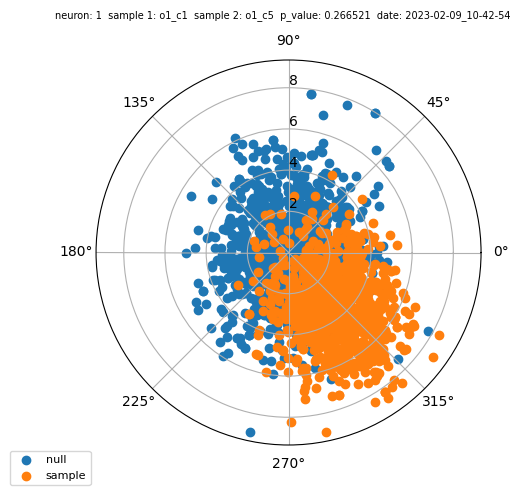

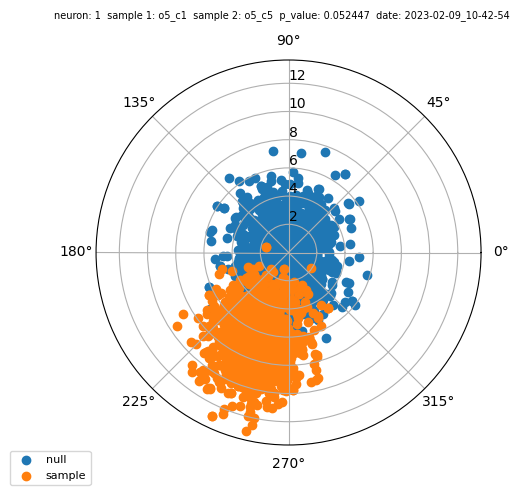

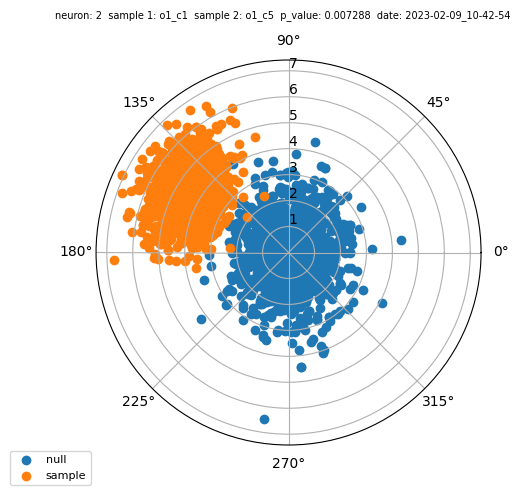

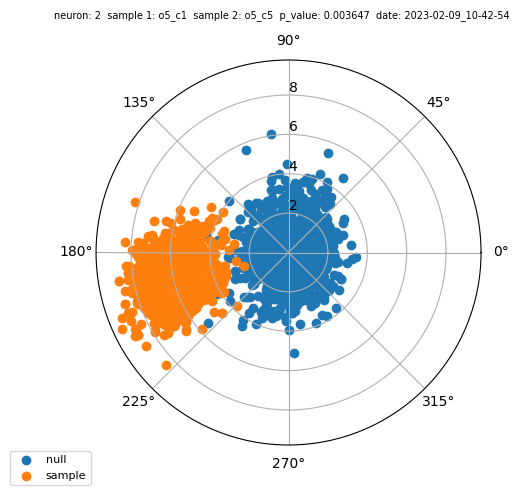

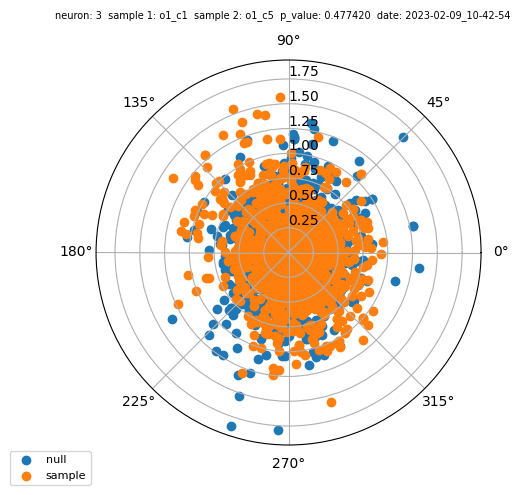

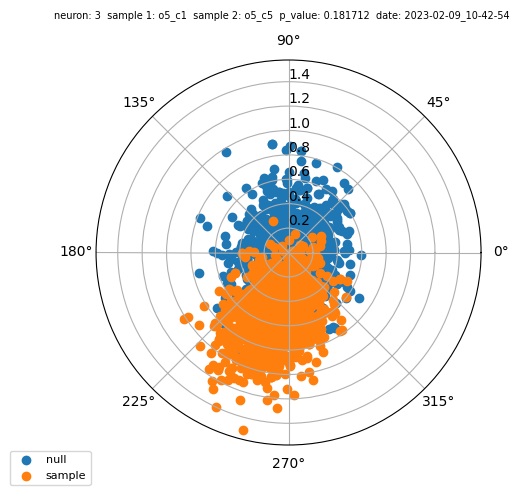

In [37]:
# definir dataframe y agregar neurona y p value para cada orientacion
selectivity_info: Dict[str, list] = defaultdict(list)

for n_bhv,n_sp in zip(paths_bhv[16:17],paths_sp[16:17]):
    s_path = os.path.normpath(n_sp).split(os.sep)
    date = s_path[-1][:19]
    data = SpikeData.from_python_hdf5(n_sp)
    bhv = BhvData.from_python_hdf5(n_bhv)
    all_task, all_trial_idx = get_task_variables(data,bhv)

    for i_neuron in range(len(data.clustersgroup)):
        task_tr = np.unique(all_task['trial_idx'].values)
        trial_idx = task_tr[np.nansum(data.sp_samples[all_trial_idx[task_tr],i_neuron],axis=1)>0]
        task = all_task[np.in1d(all_task['trial_idx'] , trial_idx)]
        task = task[task['i_neuron']==i_neuron]
        test_stimuli = bhv.test_stimuli[all_trial_idx]
        code_numbers = data.code_numbers[all_trial_idx]
        code_samples = data.code_samples[all_trial_idx]
        sp_samples = data.sp_samples[all_trial_idx,i_neuron]
        
        for sample1,sample2,color_orient in zip(samp_orient_color[0],samp_orient_color[1],o_c):


            samples_dicts,n_trials = get_sample_avg_fr(task=task,sp_samples=sp_samples,test_stimuli=test_stimuli,code_samples=code_samples,color_orient=color_orient)
            
            min_n_trials = np.min(n_trials,axis=1).astype(int)
            if np.sum(min_n_trials<3)>0:
                p_value = np.nan
                mean_null = np.zeros((2,2))
                mean_select = np.zeros((2,2))
            else:
                mean_select = select_rand_trials_from_samples(sample1,sample2,samples_dicts,min_n_trials,seed,n_iterations=1000)
                mean_null = get_null_vector_from_samples(sample1,sample2,samples_dicts,min_n_trials,seed,n_iterations=1000)
                p_value = permutation_test(mean_select,mean_null)
            fig,ax = plt.subplots(figsize=(5,5),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
            ax.set_rlabel_position(90)
            #ax.set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)
            ax.scatter(mean_null[:,1],mean_null[:,0],label='null')
            ax.scatter(mean_select[:,1],mean_select[:,0],label='sample')
            fig.suptitle('neuron: %d  sample 1: %s  sample 2: %s  p_value: %f  date: %s'%(i_neuron,sample1,sample2,p_value,date),fontsize=7)

            plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

            selectivity_info['date'] += [date]
            selectivity_info['i_neuron'] += [i_neuron]
            selectivity_info['neuron_type'] += [data.clustersgroup[i_neuron]]
            selectivity_info['p_value'] += [p_value]
            selectivity_info['sample1'] += [sample1]
            selectivity_info['sample2'] += [sample2]

selectivity_info = pd.DataFrame(selectivity_info) 

In [38]:
plt.close()

In [39]:
data.clustersgroup

array(['good', 'good', 'good', 'mua'], dtype='<U4')

/tmp/ipykernel_124573/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


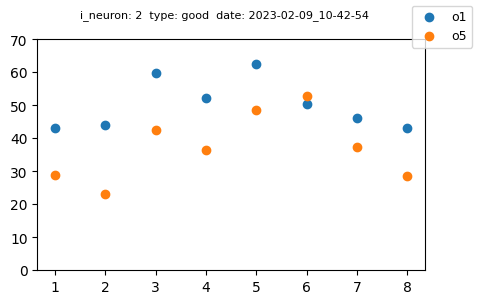

In [50]:
for n_bhv,n_sp in zip(paths_bhv[16:17],paths_sp[16:17]):
    s_path = os.path.normpath(n_sp).split(os.sep)
    date = s_path[-1][:19]
    data = SpikeData.from_python_hdf5(n_sp)
    bhv = BhvData.from_python_hdf5(n_bhv)
    # task, trial_idx = get_task_variables(data,bhv)
    all_task, all_trial_idx = get_task_variables(data,bhv)

    select_neurons = selectivity_info[np.logical_and(selectivity_info['p_value'] < 0.05,selectivity_info['date']==date)]['i_neuron'].values
    for i_neuron in np.unique(select_neurons):
        task_tr = np.unique(all_task['trial_idx'].values)
        trial_idx = task_tr[np.nansum(data.sp_samples[all_trial_idx[task_tr],i_neuron],axis=1)>0]
        task = all_task[np.in1d(all_task['trial_idx'] , trial_idx)]
        task=task[task["i_neuron"]==i_neuron]
        test_stimuli = bhv.test_stimuli[all_trial_idx]
        code_numbers = data.code_numbers[all_trial_idx]
        code_samples = data.code_samples[all_trial_idx]
        sp_samples = data.sp_samples[all_trial_idx,i_neuron]
        
        samples_dicts,n_trials = get_sample_avg_fr(task=task,sp_samples=sp_samples,test_stimuli=test_stimuli,code_samples=code_samples,color_orient=color_orient)
        
        fig, ax = plt.subplots(figsize = (5,3))

        for sample1,sample2 in zip(samp_orient_color[0],samp_orient_color[1]):

            dframes = [samples_dicts[sample1],samples_dicts[sample2]]
            merge_dicts = {}
            for k in samples_dicts[sample1].keys():
                merge_dicts[k] = np.mean(np.concatenate(list(d[k] for d in dframes),axis=0))


            label = sample1[:2] if color_orient == 0 else sample1[-2:]
            
            ax.scatter(np.arange(1,9),merge_dicts.values(),label=label)
            ax.set_ylim(0,70)      
        fig.legend(fontsize=9)
        fig.suptitle('i_neuron: %d  type: %s  date: %s'%(i_neuron,data.clustersgroup[i_neuron],date),fontsize=8)
            # min_n_trials = np.min(n_trials,axis=1).astype(int)
            # mean_select = select_rand_trials_from_samples(sample1,sample2,samples_dicts,min_n_trials,seed,n_iterations=1000)

In [41]:
plt.close()

In [42]:
## Find max fr for each neuron
max_fr_neurons: Dict[str, list] = defaultdict(list)

for n_bhv,n_sp in zip(paths_bhv[16:17],paths_sp[16:17]):
    s_path = os.path.normpath(n_sp).split(os.sep)
    date = s_path[-1][:19]
    data = SpikeData.from_python_hdf5(n_sp)
    bhv = BhvData.from_python_hdf5(n_bhv)
    # task, trial_idx = get_task_variables(data,bhv)
    all_task, all_trial_idx = get_task_variables(data,bhv)

    select_neurons = selectivity_info[np.logical_and(selectivity_info['p_value'] < 0.05,selectivity_info['date']==date)]['i_neuron'].values
    for i_neuron in np.unique(select_neurons):
        max_fr=[]
        task_tr = np.unique(all_task['trial_idx'].values)
        trial_idx = task_tr[np.nansum(data.sp_samples[all_trial_idx[task_tr],i_neuron],axis=1)>0]
        task = all_task[np.in1d(all_task['trial_idx'] , trial_idx)]
        task=task[task["i_neuron"]==i_neuron]
        test_stimuli = bhv.test_stimuli[all_trial_idx]
        code_numbers = data.code_numbers[all_trial_idx]
        code_samples = data.code_samples[all_trial_idx]
        sp_samples = data.sp_samples[all_trial_idx,i_neuron]
        
        color_samples_dicts,_ = get_sample_avg_fr_trials(task=task,sp_samples=sp_samples,test_stimuli=test_stimuli,code_samples=code_samples,color_orient=color)
        orient_samples_dicts,_ = get_sample_avg_fr_trials(task=task,sp_samples=sp_samples,test_stimuli=test_stimuli,code_samples=code_samples,color_orient=orient)
        

        for sample1,sample2 in zip(samp_orient[0],samp_orient[1]):
            dframes = [orient_samples_dicts[sample1],orient_samples_dicts[sample2]]
            for k in orient_samples_dicts[sample1].keys():
                avg_samp_trials = np.mean(np.concatenate(list(d[k] for d in dframes),axis=0),axis=0)

                d_avg = moving_average(data=avg_samp_trials,win=win,step=step) * 1000

                max_fr.append(np.max(d_avg))
        for sample1,sample2 in zip(samp_color[0],samp_color[1]):
            dframes = [color_samples_dicts[sample1],color_samples_dicts[sample2]]
            for k in color_samples_dicts[sample1].keys():
                avg_samp_trials = np.mean(np.concatenate(list(d[k] for d in dframes),axis=0),axis=0)

                d_avg = moving_average(data=avg_samp_trials,win=win,step=step) * 1000
                max_fr.append(np.max(d_avg))
            
        max_fr_neurons['date'] += [date]
        max_fr_neurons['i_neuron'] += [i_neuron]
        max_fr_neurons['neuron_type'] += [data.clustersgroup[i_neuron]]
        max_fr_neurons['max_fr'] += [np.max(max_fr)]


max_fr_neurons=pd.DataFrame(max_fr_neurons)



/tmp/ipykernel_124573/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


In [43]:
color_orient

0

/tmp/ipykernel_124573/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


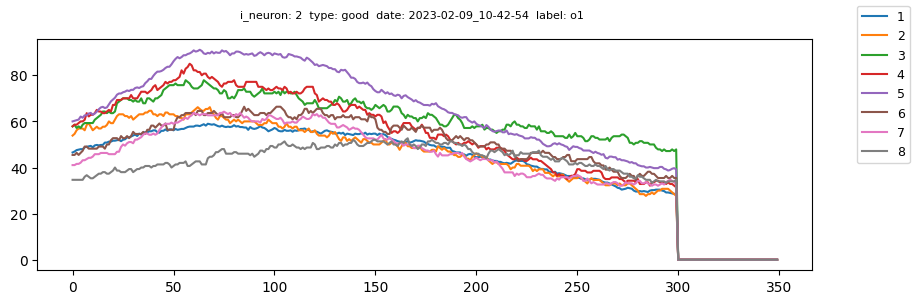

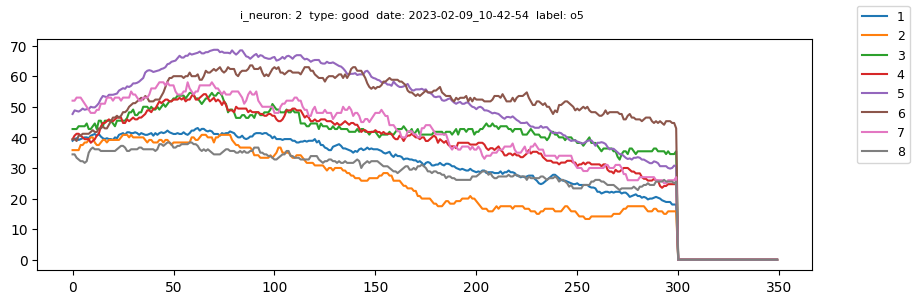

In [44]:
all_merge_dicts: Dict[str, list] = defaultdict(list)

for n_bhv,n_sp in zip(paths_bhv[16:17],paths_sp[16:17]):
    s_path = os.path.normpath(n_sp).split(os.sep)
    date = s_path[-1][:19]
    data = SpikeData.from_python_hdf5(n_sp)
    bhv = BhvData.from_python_hdf5(n_bhv)
    task, trial_idx = get_task_variables(data,bhv)
    select_neurons = selectivity_info[np.logical_and(np.logical_and(selectivity_info['p_value'] < 0.05,selectivity_info['date']==date),selectivity_info['neuron_type']!='go')]['i_neuron'].values
    
    for i_neuron in np.unique(select_neurons):
        max_fr = max_fr_neurons[np.logical_and(max_fr_neurons['i_neuron'] == i_neuron,max_fr_neurons['date']==date)]['max_fr'].values    
        test_stimuli = bhv.test_stimuli[trial_idx]
        code_numbers = data.code_numbers[trial_idx]
        code_samples = data.code_samples[trial_idx]
        sp_samples = data.sp_samples[trial_idx,i_neuron]


        samples_dicts,n_trials = get_sample_avg_fr_trials(task=task,sp_samples=sp_samples,test_stimuli=test_stimuli,code_samples=code_samples,color_orient=color_orient)
        
        for sample1,sample2 in zip(samp_orient_color[0],samp_orient_color[1]):
            dframes = [samples_dicts[sample1],samples_dicts[sample2]]
            merge_dicts = {}
            for k in samples_dicts[sample1].keys():
                samp_avg = np.mean(np.concatenate(list(d[k] for d in dframes),axis=0),axis=0)

                d_avg = moving_average(data=samp_avg,win=win,step=step) * 1000
                merge_dicts[k]=d_avg#/max_fr
            
            
   
            label = sample1[:2] if o_c[0] == 0 else sample1[-2:]
            all_merge_dicts[label] += [merge_dicts]
            # all_merge_dicts.append()
            fig, ax = plt.subplots(figsize = (10,3))
            for k, v in merge_dicts.items():                
                label = sample1[:2] if o_c[0] == 0 else sample1[-2:]
                ax.plot(v[:350],label=k)
                   
            fig.legend(fontsize=9)
            fig.suptitle('i_neuron: %d  type: %s  date: %s  label: %s'%(i_neuron,data.clustersgroup[i_neuron],date,label),fontsize=8)

In [45]:
plt.close()

In [46]:
merge_1 = {}
merge_2 = {}

for k in all_merge_dicts['c1'][0].keys():
    merge_1[k] = list(d[k] for d in all_merge_dicts['c1'])
for k in all_merge_dicts['c5'][0].keys():
    merge_2[k] = list(d[k] for d in all_merge_dicts['c5'])

IndexError: list index out of range

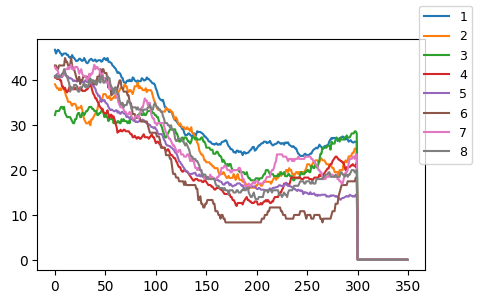

In [ ]:
fig, ax = plt.subplots(figsize = (5,3))
for k, v in merge_1.items():
    #merge_dicts[k] = np.mean(v,axis=1)
    v = np.mean(v,axis=0)
    # win=100
    # step=1
    # d_avg = np.zeros((int(np.floor(len(v)/step))))
    # count = 0
    # for i_step in np.arange(0,len(v)-step,step):
    #     d_avg[count] = np.mean(v[i_step:i_step+win])*1000
    #     count +=1        
    label = sample1[:2] if o_c[0] == 0 else sample1[-2:]
    ax.plot(v[:350],label=k)
fig.legend(fontsize=9)

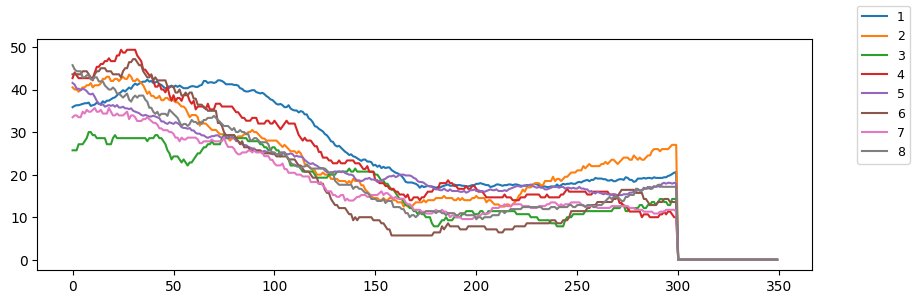

In [ ]:
fig, ax = plt.subplots(figsize = (10,3))
for k, v in merge_2.items():
    #merge_dicts[k] = np.mean(v,axis=1)
    v = np.mean(v,axis=0)
    
    label = sample1[:2] if o_c[0] == 0 else sample1[-2:]
    ax.plot(v[:350],label=k)
fig.legend(fontsize=9)

## To delete

In [ ]:
merge_dicts.values()

dict_values([array([0.62123494, 0.63253012, 0.63253012, 0.63253012, 0.63253012,
       0.63253012, 0.6438253 , 0.65512048, 0.6438253 , 0.63253012,
       0.63253012, 0.63253012, 0.60993976, 0.60993976, 0.60993976,
       0.60993976, 0.5873494 , 0.59864458, 0.60993976, 0.59864458,
       0.59864458, 0.59864458, 0.59864458, 0.57605422, 0.56475904,
       0.57605422, 0.55346386, 0.55346386, 0.54216867, 0.54216867,
       0.53087349, 0.53087349, 0.54216867, 0.53087349, 0.51957831,
       0.51957831, 0.51957831, 0.51957831, 0.48569277, 0.49698795,
       0.49698795, 0.48569277, 0.49698795, 0.49698795, 0.50828313,
       0.49698795, 0.49698795, 0.50828313, 0.51957831, 0.54216867,
       0.55346386, 0.55346386, 0.55346386, 0.53087349, 0.53087349,
       0.55346386, 0.55346386, 0.55346386, 0.55346386, 0.55346386,
       0.57605422, 0.57605422, 0.56475904, 0.57605422, 0.5873494 ,
       0.59864458, 0.59864458, 0.60993976, 0.60993976, 0.60993976,
       0.60993976, 0.63253012, 0.62123494, 0.6099

In [ ]:
plt.close()

In [ ]:
mean_null

array([[1.04615469, 2.68617302],
       [0.46536997, 2.61292609],
       [1.222368  , 4.71069233],
       ...,
       [0.29669175, 0.48693826],
       [1.46949098, 5.95949602],
       [1.43038333, 0.31678025]])

In [ ]:
from ephysvibe.analysis import circular_stats

In [ ]:
circular_stats.mean_vector([1,4], [45*np.pi/180,225*np.pi/180])

(1.5000000000000002, 3.926990816987241)

In [ ]:
data = SpikeData.from_python_hdf5(n_sp)
bhv = BhvData.from_python_hdf5(n_bhv)
task, trial_idx = get_task_variables(data,bhv)
n_neurons = data.sp_samples.shape[1]
for feature in ['o1','o5']:    
    
    if feature == 'c1' or feature == 'c5':
        test_color = '1'
        color_orient = 1
        if feature == 'c5':
            test_color = '5'
    else:
        test_orient = '1'
        color_orient = 0
        if feature == 'o5':
            test_orient = '5'

    stim_num=['1','2','3','4','5','6','7','8']


    # Do not take into account trials in wich the match is in the first test
    task = task[task['n_test_stimuli'] > 1]
    test_stimuli,code_numbers,code_samples,sp_samples,sample_trials = get_trials_by_sample(task,feature,trial_idx,bhv,data)
    test_stimuli = delete_match(test_stimuli) # select only non-matching tests

    shift_sp = []
    for i_stim in stim_num:
        i_trial, i_test = np.where(np.char.find(test_stimuli,i_stim)==color_orient)
        tests_on = code_samples[i_trial,i_test+6].astype(int)
        sp_stim = sp_samples[i_trial]
        shifts = tests_on[:,np.newaxis]
        sp_tests = SpikeData.indep_roll(sp_stim, -shifts, axis=2)[:,:, 100:400]
        shift_sp.append(sp_tests.mean(axis=0))
        n_spikes = np.nansum(sp_stim,axis=2)
        for i, tr in enumerate(i_trial):
            sample = task[task['trial_idx']==sample_trials[feature][tr]]['sample'].values[0]
            # I do not take into account trials with 0 spikes
            bool_active_neu = np.where(n_spikes[i] >0, True,False)
            neuron = (np.arange(0,n_neurons)[bool_active_neu]).tolist()
            
            # complete df
            df["sample"] += [sample]*sum(bool_active_neu)
            df['fr'] += (np.mean(sp_tests[i],axis=1)[bool_active_neu]).tolist()
            df['neuron'] += neuron
            if color_orient == 1:
                df["test_color"] += [test_color]*sum(bool_active_neu)
                df["test_orient"] += [i_stim]*sum(bool_active_neu)
            if color_orient == 0:
                df["test_color"] += [i_stim]*sum(bool_active_neu)
                df["test_orient"] += [test_orient]*sum(bool_active_neu)

    shift_sp=np.array(shift_sp)

    sp_avg = moving_average(data=np.array(shift_sp),win=100, step=1) 
    sp_avg = np.mean(sp_avg,axis=2)

    sp_avg_all.append(sp_avg)
sp_avg_all = np.concatenate(sp_avg_all,axis=1)

sp_avg_features.append(sp_avg_all)
df = pd.DataFrame(df)

TypeError: delete_match() missing 1 required positional argument: 'code'

### ANOVA: Color and direction selectivity

* 3-way ANOVA
* with sample identity (A, B, C or D), test color, and test direction as factors
* Only included non-matching test stimuli
* Period selectivity for each neuron: fixed time window between 100 and 400 ms following test onset
* main effect of (either factor) and/or (interaction between direction/color and sample identity)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
df: Dict[str, list] = defaultdict(list)
sp_avg_features = []
for n_bhv,n_sp in zip(paths_bhv[3:4],paths_sp[3:4]):
    sp_avg_all = []
    # Read data
    data = SpikeData.from_python_hdf5(n_sp)
    bhv = BhvData.from_python_hdf5(n_bhv)
    task, trial_idx = get_task_variables(data,bhv)
    n_neurons = data.sp_samples.shape[1]
    for feature in ['c1','c5','o1','o5']:    
     
        if feature == 'c1' or feature == 'c5':
            test_color = '1'
            color_orient = 1
            if feature == 'c5':
                test_color = '5'
        else:
            test_orient = '1'
            color_orient = 0
            if feature == 'o5':
                test_orient = '5'

        stim_num=['1','2','3','4','5','6','7','8']


        # Do not take into account trials in wich the match is in the first test
        task = task[task['n_test_stimuli'] > 1]
        test_stimuli,code_numbers,code_samples,sp_samples,sample_trials = get_trials_by_sample(task,feature,trial_idx,bhv,data)
        test_stimuli = delete_match(test_stimuli) # select only non-matching tests

        shift_sp = []
        for i_stim in stim_num:
            i_trial, i_test = np.where(np.char.find(test_stimuli,i_stim)==color_orient)
            tests_on = code_samples[i_trial,i_test+6].astype(int)
            sp_stim = sp_samples[i_trial]
            shifts = tests_on[:,np.newaxis]
            sp_tests = SpikeData.indep_roll(sp_stim, -shifts, axis=2)[:,:, 100:400]
            shift_sp.append(sp_tests.mean(axis=0))
            n_spikes = np.nansum(sp_stim,axis=2)
            for i, tr in enumerate(i_trial):
                sample = task[task['trial_idx']==sample_trials[feature][tr]]['sample'].values[0]
                # I do not take into account trials with 0 spikes
                bool_active_neu = np.where(n_spikes[i] >0, True,False)
                neuron = (np.arange(0,n_neurons)[bool_active_neu]).tolist()
                
                # complete df
                df["sample"] += [sample]*sum(bool_active_neu)
                df['fr'] += (np.mean(sp_tests[i],axis=1)[bool_active_neu]).tolist()
                df['neuron'] += neuron
                if color_orient == 1:
                    df["test_color"] += [test_color]*sum(bool_active_neu)
                    df["test_orient"] += [i_stim]*sum(bool_active_neu)
                if color_orient == 0:
                    df["test_color"] += [i_stim]*sum(bool_active_neu)
                    df["test_orient"] += [test_orient]*sum(bool_active_neu)

        shift_sp=np.array(shift_sp)

        sp_avg = moving_average(data=np.array(shift_sp),win=100, step=1) 
        sp_avg = np.mean(sp_avg,axis=2)

        sp_avg_all.append(sp_avg)
    sp_avg_all = np.concatenate(sp_avg_all,axis=1)
    sp_avg_features.append(sp_avg_all)
df = pd.DataFrame(df)

In [ ]:
color_selec_neu = []

for i_neu in range(n_neurons):
    df_neu = df[df['neuron']==i_neu].reset_index(drop=True)
    #perform three-way ANOVA
    # model = ols("""fr ~ C(sample) + C(test_color) + C(test_orient)+ C(sample):C(test_color) + C(sample):C(test_orient) + C(test_color):C(test_orient)""", data=df_neu).fit()
    model = ols("""fr ~ C(sample) + C(test_color) + C(test_orient) + C(sample):C(test_color) + C(sample):C(test_orient) + C(test_color):C(test_orient)""", data=df_neu).fit()

    anova_res = sm.stats.anova_lm(model, typ=3)
    anova_p = anova_res.loc[:,'PR(>F)']
    signif = np.any(np.array([anova_p['C(test_color)'],anova_p['C(sample):C(test_color)']])<0.05)
    color_selec_neu.append(signif)


c:\Users\camil\.virtualenvs\EphysVibe-BeirVkCw\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 19
  warnings.warn('covariance of constraints does not have full '
c:\Users\camil\.virtualenvs\EphysVibe-BeirVkCw\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 20
  warnings.warn('covariance of constraints does not have full '
c:\Users\camil\.virtualenvs\EphysVibe-BeirVkCw\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 49, but rank is 13
  warnings.warn('covariance of constraints does not have full '
c:\Users\camil\.virtualenvs\EphysVibe-BeirVkCw\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of co

In [ ]:
sp_avg_features = []
for feature in ['c1','c5']:
    sp_avg_all = []
    for n_bhv,n_sp in zip(paths_bhv[3:4],paths_sp[3:4]):
        # op_feature = 'o5'
        orientation = 0
        color = 1
        color_orient = color
        stim_num=['1','2','3','4','5','6','7','8']

        # Read data
        data = SpikeData.from_python_hdf5(n_sp)
        bhv = BhvData.from_python_hdf5(n_bhv)
        task, trial_idx = get_task_variables(data,bhv)
        
        # Do not take into account trials in wich the match is in the first test
        task = task[task['n_test_stimuli'] > 1]
        test_stimuli,code_numbers,code_samples,sp_samples,sample_trials = get_trials_by_sample(task,feature,trial_idx,bhv,data)
        test_stimuli = delete_match(test_stimuli) # select only non-matching tests

        shift_sp = []
        for i in stim_num:
            i_trial, i_test = np.where(np.char.find(test_stimuli,i)==color_orient)
            tests_on = code_samples[i_trial,i_test+6].astype(int)
            sp_stim = sp_samples[i_trial]
            shifts = tests_on[:,np.newaxis]
            shift_sp.append(SpikeData.indep_roll(sp_stim, -shifts, axis=2)[:,:, 100:400].mean(axis=0))
        shift_sp=np.array(shift_sp)

        sp_avg = moving_average(data=np.array(shift_sp),win=100, step=1) 
        sp_avg = np.mean(sp_avg,axis=2)

        sp_avg_all.append(sp_avg)
    sp_avg_all = np.concatenate(sp_avg_all,axis=1)
    sp_avg_features.append(sp_avg_all)

In [ ]:
sp_avg_features[1].shape

(8, 5)

In [ ]:
rad, ang = circular_stats.mean_vector(
    radius=norm_fr_max[significant],
    angle=fr_angle_rad[:-1][significant],
)

NameError: name 'norm_fr_max' is not defined

In [ ]:
stim_position = {'stim_num':['1','2','3','4','5','6','7','8'],'stim_angle':[0,45,90,135,180,225,270,315]}

In [ ]:
color_selec_neu

[False, False, False, True, False]

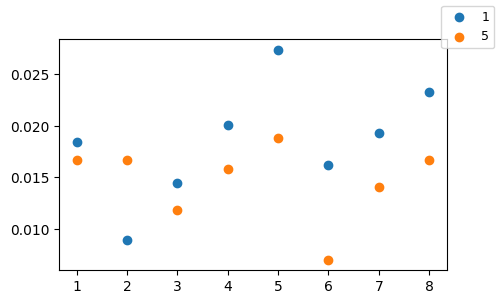

In [ ]:
for i_n in np.arange(sp_avg_features[0].shape[1]):#[np.array(color_selec_neu)]:
    fig, ax = plt.subplots(figsize = (5,3))
    y_avg1 = sp_avg_features[0][:,i_n]#np.mean(sp_avg_all,axis=1)
    y_avg5 = sp_avg_features[1][:,i_n]
 
    # rad, ang = circular_stats.mean_vector(
    #     radius=norm_fr_max[significant],
    #     angle=fr_angle_rad[:-1][significant],
    # )

    ax.scatter(np.arange(1,9),y_avg1,label='1')
    ax.scatter(np.arange(1,9),y_avg5,label='5')
    fig.legend(fontsize=9)

In [ ]:
plt.close()

In [ ]:
# 1 aligne sample presentation
# 2 split by sample 
# 3 compute avg (throw time) for each sample
# 4 compute t-test 

In [ ]:
sp_avg_all = []

for n_bhv,n_sp in zip(paths_bhv[3:4],paths_sp[3:4]):
    
    feature = 'c5'
    #op_feature = 'c5'
    orientation = 0
    color = 1
    color_orient = color
    stim_num=['1','2','3','4','5','6','7','8']

    # Read data
    data = SpikeData.from_python_hdf5(n_sp)
    bhv = BhvData.from_python_hdf5(n_bhv)
    task, trial_idx = get_task_variables(data,bhv)
    
    # Select trials with more than one trial
    task = task[task['n_test_stimuli'] > 1]
    test_stimuli,code_numbers,code_samples,sp_samples,sample_trials = get_trials_by_sample(task,feature,trial_idx,bhv,data)
    test_stimuli = delete_match(test_stimuli)

    shift_sp = []
    for i in stim_num:
        i_trial, i_test = np.where(np.char.find(test_stimuli,i)==color_orient)
        tests_on = code_samples[i_trial,i_test+6].astype(int)
        sp_stim = sp_samples[i_trial]
        shifts = tests_on[:,np.newaxis]
        shift_sp.append(SpikeData.indep_roll(sp_stim, -shifts, axis=2)[:,np.array(color_selec_neu), :450].mean(axis=0))
    shift_sp=np.array(shift_sp)

    sp_avg = moving_average(data=np.array(shift_sp),win=100, step=1) 
    neurons_max = np.max(sp_avg,axis=0)
    neurons_max = np.where(neurons_max==0,1,neurons_max)
    neurons_max = neurons_max[np.newaxis,:]
    sp_avg = sp_avg/(neurons_max)
    sp_avg_all.append(sp_avg)
sp_avg_all = np.concatenate(sp_avg_all,axis=1)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 5 but corresponding boolean dimension is 6